# Lab-03 : Grover's Algorithm and Fourier Checking Circuit

### Qiskit Aqua
> `qiskit-aqua, qiskit-chemistry, qiskit-machine-learning, qiskit-finance, qiskit-optimization` are cross-domain libraries and domain-specific application and stack build upon it. It provides applications in the following areas like 
> 1. Machine Learning
> 2. Chemistry
> 3. Finance
> 4. Optimization

### Qiskit for Machine Learning
Qiskit's Machine Learning Library provides a set of tools, algorithms and software for use with quantum computers to carry out research and investigate how to take advantage of quantum computing power to solve machine learning problems.

We are going to build our first algorithms from the circuits library. Question arises, What we needed ?
- Some Data as Input 
- Circuit for running calculations
- Resultent output

In Physics, We talk about signal which transmitts the information for this we uses the basis/units like frequency/time to represent the kind of information that we transmitts.

We will use an algoriths that is build-in qiskit circuit library called Fourier Checking Circuit(FCC), it is used in signal processing domain and also used in many other algorithms as fundamentals like in Shor's Algorithms.

There Quantum Circuits can be run on the Real Quantum Computers or even High Performance Simulators.


### Fourier checking circuit.

The circuit for the Fourier checking algorithm, introduced in [1],
involves a layer of Hadamards, the function f, another layer of
Hadamards, the function g, followed by a final layer of Hadamards.
The functions f and g are classical functions realized as phase oracles (diagonal operators with {-1, 1} on the diagonal).

The probability of observing the all-zeros string is p(f,g). The algorithm solves the promise Fourier checking problem, which decides if f is correlated with the Fourier transform
of g, by testing if p(f,g) <= 0.01 or p(f,g) >= 0.05, promised that one or the other of these is true.

The functions f and g are currently implemented from their truth tables but could be represented concisely and implemented efficiently for special classes of functions

In [1]:
from qiskit import *
from qiskit_aer import Aer
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi
from qiskit.circuit.library import FourierChecking
from qiskit.visualization import plot_histogram

import matplotlib.pyplot as plt
import numpy as np

In [16]:
# 1, -1, -1, -1, 
f = [-1, -1,-1, 1, 1, 1, 1, 1]
g = [ 1, 1, 1, 1, -1, -1, -1, 1]
# 1, 1, -1, -1,
# FourierChecking() : How our Fourier Transform of F is correlated with G.
# if p(f,g) <= 0.01
# p(f, g) > 0.05 Fourier Exits between f and g

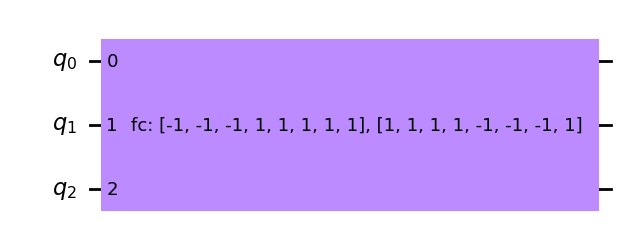

In [17]:
qc = FourierChecking(f=f, g=g)
qc.draw(output='mpl')

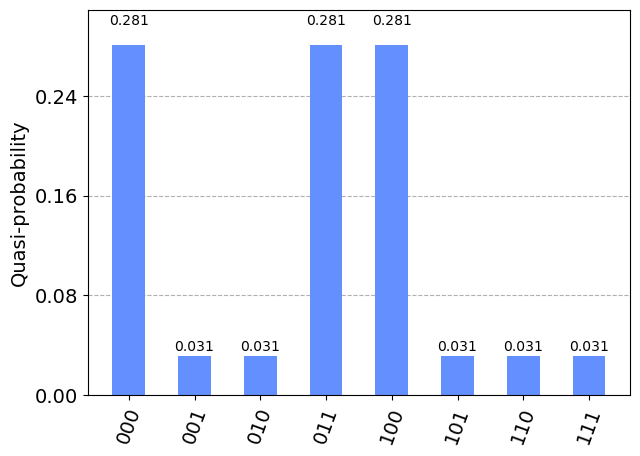

In [18]:
zero = qi.Statevector.from_label('000')
sv = zero.evolve(qc)
probs = sv.probabilities_dict()
plot_histogram(probs)

We are only interested in 000 qubit thus our function f is correlated in 000 state to g with probabilites of 28.1%

### Grover's Algorithm
**What Quantum Algorithm is and What advantages they provides over the classical algorithms ?**

> A Qauntum Algorithm is a set of instrcution which runs of Quantum Computers, which exploits the concepts of qauntum mechanics like Superposition, entanglement and inferences while the classical algorithms run on our computers which uses the binary logics.

Problems That we are going to solve using Grover's Algrithm i.e How a quantum computer approaches a problem vs Classical computers ? How to implement Grover's algorithms in qiskit ?.

Lets we have unsorted list of N elements, and we have one element with us which is located in list somewhere and we needed to find that element.

We model such problems using Oracle i.e black-box.

In [3]:
my_list = [1,2,3 ,4,5, 6,8,8,3,23,7,75,54,3]

In [4]:
def my_oracle(my_input):
    winner=7
    if my_input is winner:
        response = True
    else:
        response = False
    return response
    

In [5]:
for index, trial_number in enumerate(my_list):
    if my_oracle(trial_number) is True:
        print('Winner found at index :%i'%index)
        print('%i calls to the Oracle used'%(index+1))
        break
        

Winner found at index :10
11 calls to the Oracle used


So, The complexity of finding our element is the $O(N)$ but on quantum computing $O(\sqrt N )$

### Quantum Circuits

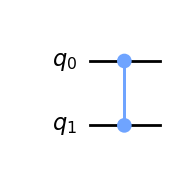

In [7]:
oracle = QuantumCircuit(2, name='oracle')
oracle.cz(0,1)
oracle.to_gate()
oracle.draw(output='mpl')

### Superposition

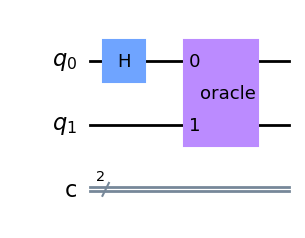

In [8]:
backend = Aer.get_backend('statevector_simulator')
grover_circ = QuantumCircuit(2,2)
grover_circ.h(0)
grover_circ.append(oracle,[0,1])
grover_circ.draw(output='mpl')

In [9]:
job = execute(grover_circ, backend)
result = job.result()

In [14]:
sv = result.get_statevector()
print(np.around(sv, 2))
sv.draw(output="latex")


[ 0.71+0.j  0.71+0.j  0.  +0.j -0.  +0.j]


<IPython.core.display.Latex object>

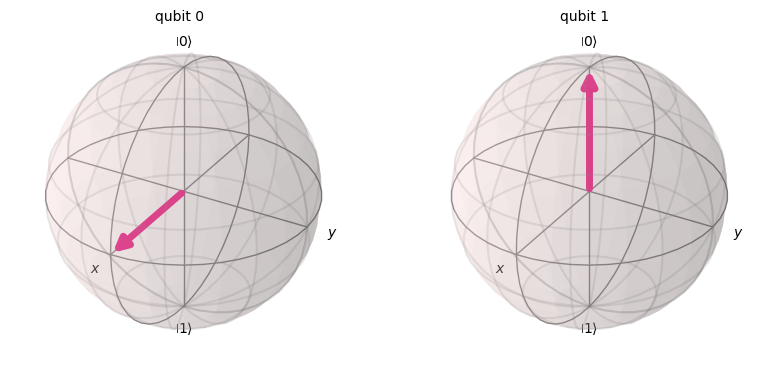

In [19]:
from qiskit.visualization import plot_bloch_multivector, plot_histogram

plot_bloch_multivector(sv)

### Amplification
To get the probabilities of state vector measurement we needed to take the square of the state vector i.e $$P(x)=\bra x c^{*} c\ket x = |c|^{2}$$

Problem of minus sign in our state vector measurement that's why we use reflection operator with oracle we can perform the amplitude amplification i.e to amplify the probabilities of the winning state and reduce the probability of non-winning state.

Winning State : $\ket w = [0,0,0,1] = \ket {11}$

Superposition State : $ \ket s = \frac{1}{2}[1, 1, 1, 1]$

New State within w and s : $\ket s' = \frac{1}{\sqrt 3}[1, 1, 1, 1]$.

$$Oracle(\ket s) =  \frac{1}{2}[1, 1, 1, -1]$$



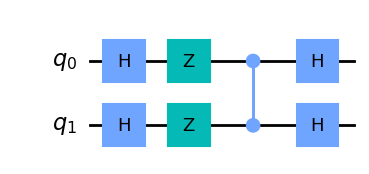

In [16]:
reflection = QuantumCircuit(2, name = 'reflection')
ref = reflection
ref.h([0, 1])
ref.z([0, 1])
ref.cz(0, 1)
ref.h([0, 1])
ref.to_gate()
ref.draw(output = "mpl")


### Reflection Operator
$$\ket s \bra s \mathbb{-I}$$

The Number of times we should apply the amplitude amplification will raised to $\sqrt{N}$

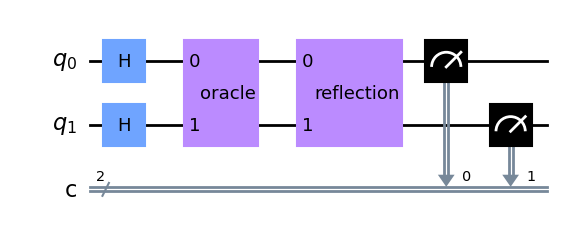

In [17]:
backend = Aer.get_backend('qasm_simulator')
qc = QuantumCircuit(2, 2)
qc.h([0,1])
qc.append(oracle, [0,1])
qc.append(ref,[0,1] )
qc.measure([0, 1], [0, 1])
qc.draw(output="mpl")

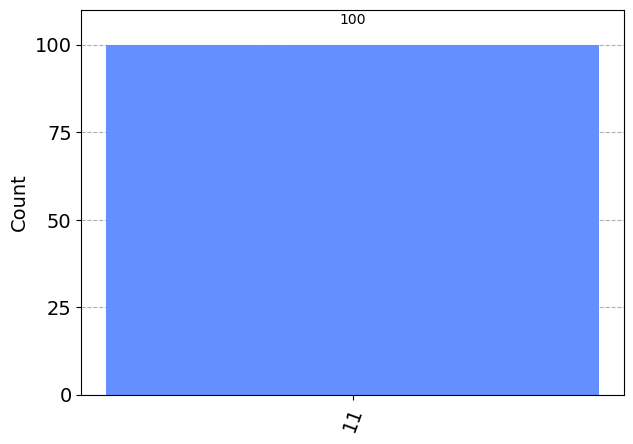

In [20]:
job = execute(qc, backend, shots=100)
result = job.result()
count = result.get_counts()
plot_histogram(count)

## Conclusion
- We are only interested in $\ket {000}$ qubit thus our function f is correlated in $\ket {000}$ state to g with probabilites of 28.1%
- You can see here after amplification of the our result we get it with 100% accuracy after measuring the state of the qubit $\ket {11}$

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table